> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

-- 7 Subjects, therefore pure guessing would be 14.28% correct on average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data

In [6]:
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

with open('Data\cphs_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, poss_block1, _, _, _, Ws_block1, _, _, _, times_block1, _ = pickle.load(handle)

with open('Data\cphs_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    refs_block2, poss_block2, _, _, _, Ws_block2, _, _, _, times_block2, _ = pickle.load(handle)
    
update_ix = np.load(r"Data\update_ix.npy")
print(update_ix.shape)
print(update_ix)

In [14]:
# learning rate conditions
slow = [4, 5, 6, 7] # slow --> alpha = 0.75 bc 
fast = [0, 1, 2, 3]
# initialization conditions
pos_init = [0, 1, 4, 5]
neg_init = [2, 3, 6, 7]
# penalty parameter conditions
pD_3 = [0, 2, 4, 6] # pD = 1e-3
pD_4 = [1, 3, 5, 7] # pD = 1e-4

# Took these from 000, look at that NB to see how they are calculated
conds = ['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7', 'D_8']
min_time = 20770
RAMP = 350
tscale = 70.08502828627614

# choosing some random subject/condition that's done reasonably well (a.k.a. "representative subject")
k = keys[0]
c = 6
print(k)
print(conds[c])

# first minute
s0 = 0
s1 = int(min_time/5)

# last minute
s2 = int(4/5*min_time)
s3 = min_time

METACPHS_S106
D_7


## Plot Accuracy As a Func of N

In [18]:
# Instead, load these in
# df = pd.read_pickle(file_name)

lr_df = full_test_df[full_test_df['Algorithm']=='LogisticRegression()']
knn_df = full_test_df[full_test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = full_test_df[full_test_df['Algorithm']=='LinearSVC()']
dt_df = full_test_df[full_test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = full_test_df[full_test_df['Algorithm']=='GradientBoostingClassifier()']

In [38]:
plt.figure(figsize=(9,7))
plt.plot(list(range(19)), lr_df.iloc[:, 2], label='LogReg')
plt.plot(list(range(19)), knn_df.iloc[:, 2], label='KNN')
plt.plot(list(range(19)), svc_df.iloc[:, 2], label='SVC')
plt.plot(list(range(19)), dt_df.iloc[:, 2], label='DTree')
plt.plot(list(range(19)), gbt_df.iloc[:, 2], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

NameError: name 'lr_df' is not defined

<Figure size 900x700 with 0 Axes>

In [39]:
my_x_updates = list(range(19))[2:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[2:, 2], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[2:, 2], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[2:, 2], label='SVC')
plt.plot(my_x_updates, dt_df.iloc[2:, 2], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[2:, 2], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

NameError: name 'lr_df' is not defined

<Figure size 900x700 with 0 Axes>

# Plot Adversarial Model Acc VS User Error

## Original Figure and Code from CPHS

In [32]:
print(type(refs_block1))
print(len(refs_block1))
print()
print(refs_block1[k].shape)
print(refs_block1[k][0].shape)
print(poss_block1[k][0].shape)
temp = calc_time_domain_error(refs_block1[k][0], poss_block1[k][0])
temp.shape

<class 'dict'>
7

(8, 20770, 2)
(20770, 2)
(20770, 2)


(20770,)

first 20 seconds after ramp, starting at index:  350 ending at index:  1751
last 20 seconds, starting at index:  1401


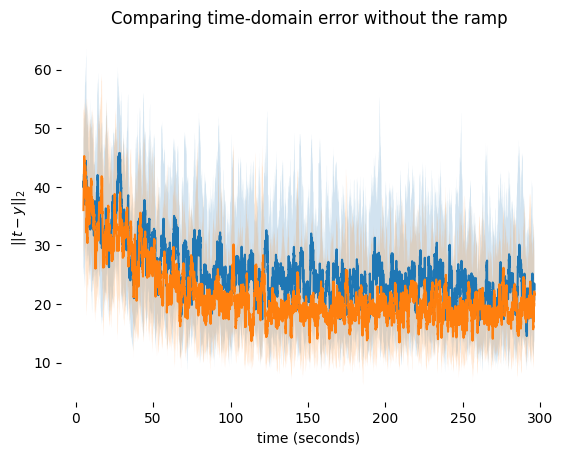

In [33]:
# Calculate the average time-domain error across all subjects

time_x = times_block1[k][c]
td_error = np.empty((2, len(keys), len(conds), min_time)) # len(update_ix)-2 so we can avoid the last interval

# get the time-domain error average across batches
for iK, key in enumerate(keys):
    for iC, cond in enumerate(conds):
        # BLOCK 1
        b = 0
        ref = refs_block1[key][iC] # ref = time x 2
        pos = poss_block1[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
        # BLOCK 2
        b = 1
        ref = refs_block2[key][iC] # ref = time x 2
        pos = poss_block2[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
# first 20 seconds after ramp 
t0_start = RAMP 
t0_end = int(tscale*25)-1 # so that both times are the same 
print("first 20 seconds after ramp, starting at index: ", t0_start, "ending at index: ", t0_end)

# take the average of the first 20 seconds across subjects, blocks and conditions
td_error_first = np.mean(td_error[:, :, :, t0_start:t0_end], axis = -1) # 2 x 7 x 8
assert(td_error_first.shape == (2, len(keys), len(conds)))

# last 20 seconds
t1_end = int(tscale*20)
print("last 20 seconds, starting at index: ", t1_end)

# make sure that the time lengths are the same
assert((t0_end - t0_start) == t1_end)

# take average of the last 20 seconds, across subjects blocks and conditions
td_error_last = np.mean(td_error[:, :, :, -t1_end:], axis=-1) # -t1_end takes the last 20 seconds index
assert(td_error_last.shape == (2, len(keys), len(conds)))

# BLOCK 1 - without the 5 seconds ramp
b = 0
td_b1_25, td_b1_50, td_bl_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b1_50)
plt.fill_between(time_x[t0_start:], td_b1_25, td_bl_75, alpha=0.2)

# BLOCK 2 - without the 5 seconds ramp
b = 1
td_b2_25, td_b2_50, td_b2_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b2_50)
plt.fill_between(time_x[t0_start:], td_b2_25, td_b2_75, alpha=0.2)

plt.title("Comparing time-domain error without the ramp")
plt.xlabel("time (seconds)")
plt.ylabel("$||t - y||_2$")
plt.box(False)

## Adapting CPHS to plot with adversarial model

In [35]:
td_b2_50[update_ix - t0_start]

array([18.9927478 , 40.38896868, 30.58622744, 30.56379275, 18.71611393,
       21.06245536, 27.66208124, 22.70015623, 18.41970691, 18.36723567,
       20.8748816 , 13.80956191, 17.82973326, 18.27801767, 18.71170382,
       17.9488668 , 17.93403196, 20.14721079, 21.55615049])